In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df_patient_act = pd.read_excel('patient_activity_01.xlsx')
df_patient_act

,TIMESTAMP,ACTIVITY
0,2009-02-23 16:00:00,0
1,2009-02-23 16:01:00,195
2,2009-02-23 16:02:00,240
3,2009-02-23 16:03:00,209
4,2009-02-23 16:04:00,202
...,...,...
8631,2009-03-01 15:51:00,0
8632,2009-03-01 15:52:00,0
8633,2009-03-01 15:53:00,0
8634,2009-03-01 15:54:00,131


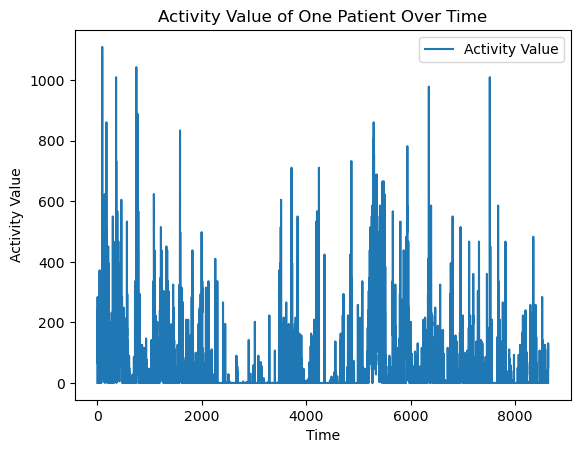

In [3]:
# visualize the time series
plt.plot(df_patient_act['ACTIVITY'], label='Activity Value')
plt.xlabel('Time')
plt.ylabel('Activity Value')
plt.legend()
plt.title('Activity Value of One Patient Over Time')
plt.show();

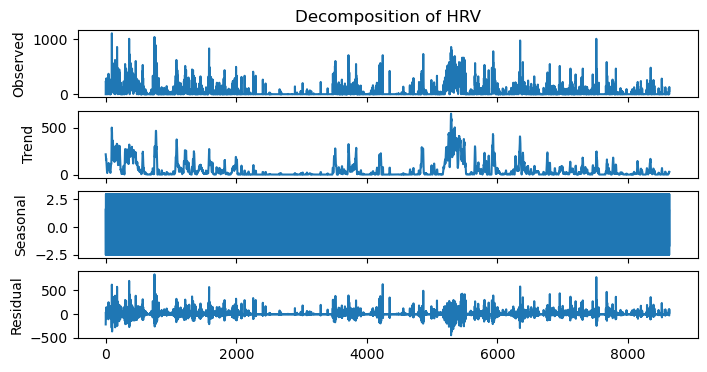

In [4]:
# Checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
# can change model='multiplicative' to see if there's a change in seasonal trend
decomp1 = seasonal_decompose(df_patient_act['ACTIVITY'], period=10, model='additive', extrapolate_trend='freq')
# decomp2 = seasonal_decompose(data['Close'], period=5, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

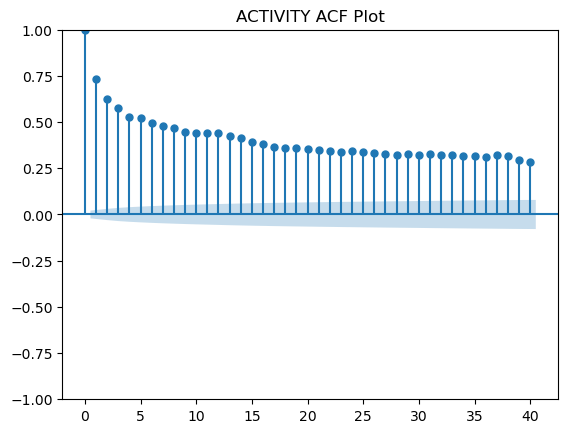

In [5]:
# Autocorrelation Function
# This is used to determine the appropriate lag

# use the original data
series = df_patient_act['ACTIVITY']
plot_acf(series, title = 'ACTIVITY ACF Plot')
plt.show();
# Looks like even up to a lag of 10 could provide significant information about the ensuing years

C:\Users\miche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


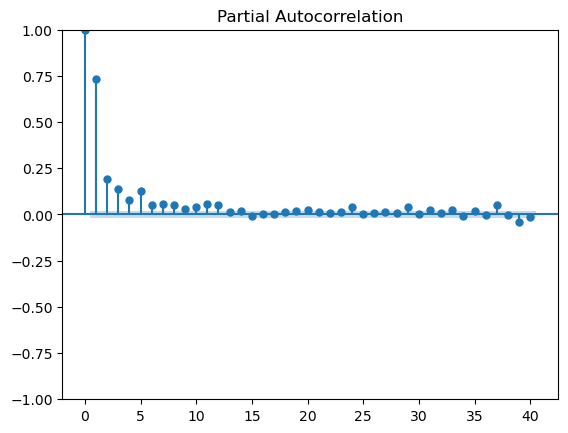

In [18]:
# plot partial autocorrelation function (PACF)
# PACF drops faster, therefore AR model should be better?
plot_pacf(series)
plt.show();

In [6]:
# Split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
# Take instead the first 80% for the training, then we'll see if the first 80% of MLB history can be used to predict the next 20%
train_size = int(.8 * len(df_patient_act))
train_data = df_patient_act[:train_size]
test_data = df_patient_act[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['ACTIVITY']).reshape(-1,1)
y_test = np.array(test_data['ACTIVITY']).reshape(-1,1)

In [27]:
# fit using packages (should do this manually if AR model is good)
# Using statsmodels AutoReg function

ar_model = AutoReg(y_train, lags=50, trend='n') # the default is to add an intercept (or, trend='c'), 
# using trend='n' is more in line with traditional AR(p) models, but may result in a nonstationary model
ar_results = ar_model.fit()

In [28]:
# look to see if it aligns with stationary principal?
ar_results.params
ar_results.roots

array([ 1.00774125-0.j        ,  1.05920631-0.13477902j,
        1.05920631+0.13477902j,  1.05122013-0.24613404j,
        1.05122013+0.24613404j,  0.98323659-0.39201479j,
        0.98323659+0.39201479j,  0.9157167 -0.52882022j,
        0.9157167 +0.52882022j,  0.84626514-0.66936084j,
        0.84626514+0.66936084j,  0.70190177-0.80254003j,
        0.70190177+0.80254003j,  0.55806726-0.88595622j,
        0.55806726+0.88595622j,  0.86539011-0.84510315j,
        0.86539011+0.84510315j,  0.41621204-0.97259535j,
        0.41621204+0.97259535j, -1.06796211-0.09197056j,
       -1.06796211+0.09197056j, -1.00287787-0.31874773j,
       -1.00287787+0.31874773j, -1.10815518-0.18964606j,
       -1.10815518+0.18964606j, -0.94524752-0.47398181j,
       -0.94524752+0.47398181j, -0.87978926-0.59427353j,
       -0.87978926+0.59427353j, -0.79669263-0.73345948j,
       -0.79669263+0.73345948j, -0.72382895-0.80001282j,
       -0.72382895+0.80001282j, -0.5889752 -0.8836142j ,
       -0.5889752 +0.8836142j ,

In [29]:
# the predictions
ar_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred ACTIVITY': ar_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred ACTIVITY
Time,
6908,4.386579
6909,5.716556
6910,0.696140
6911,9.966344
6912,7.106463


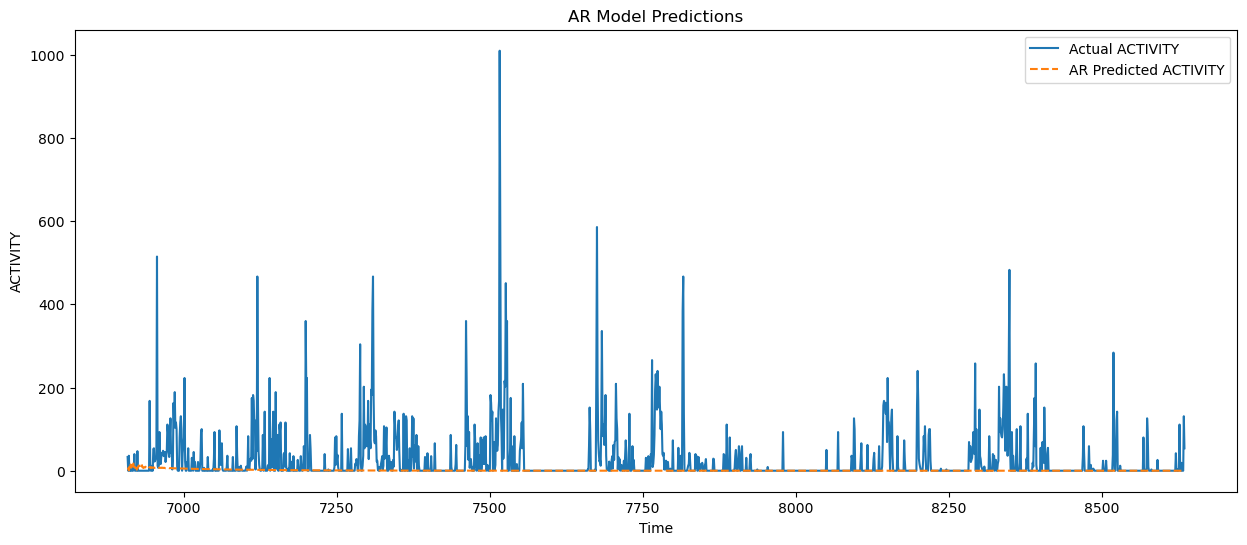

In [30]:
# make the plot
plt.figure(figsize=(15, 6))

plt.plot(test_data['ACTIVITY'], label = 'Actual ACTIVITY')
plt.plot(pred_data['pred ACTIVITY'], label = 'AR Predicted ACTIVITY', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('ACTIVITY')
plt.legend()
plt.title('AR Model Predictions')
plt.show();

In [21]:
# calculate the mae and rmse for the model performance on the test set
mae = mean_absolute_error(y_test, ar_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test, ar_pred.flatten()))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 26.20
Root Mean Squared Error: 69.34


In [14]:
ma_model = ARIMA(y_train, order=(0, 0, 25)) # here is the MA(1) model
ma_results = ma_model.fit()

#summary of the model
ma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6908
Model:                ARIMA(0, 0, 25)   Log Likelihood              -39521.118
Date:                Mon, 31 Mar 2025   AIC                          79096.237
Time:                        20:10:22   BIC                          79280.929
Sample:                             0   HQIC                         79159.921
                               - 6908                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.2093      8.026      7.004      0.000      40.480      71.939
ma.L1          0.5421      0.006     95.005      0.000       0.531       0.553
ma.L2          0.3817      0.007     55.348      0.000       0.368       0.395
ma.L3          0.3436      0.008     43.951      0.000       0.328       0.359
ma.L4          0.2567      0.009     29.475      0.000       0.240       0.274
ma.L5          0.2795      0.009     31.179      0.000       0.262       0.297
ma.L6          0.2486      0.010     26.092      0.000       0.230       0.267
ma.L7          0.2315      0.009     24.567      0.000       0.213       0.250
ma.L8          0.2286      0.009     24.985      0.000       0.211       0.247
ma.L9          0.1953      0.010     19.488      0.000       0.176       0.215
ma.L10         0.1749      0.010     16.735      0.000       0.154       0.195
ma.L11         0.1939      0.011     17.920      0.000       0.173       0.215
ma.L12         0.2087      0.011     19.789      0.000       0.188       0.229
ma.L13         0.1990      0.010     19.916      0.000       0.179       0.219
ma.L14         0.2036      0.010     20.178      0.000       0.184       0.223
ma.L15         0.1712      0.011     16.199      0.000       0.150       0.192
ma.L16         0.1519      0.011     13.994      0.000       0.131       0.173
ma.L17         0.1289      0.010     12.491      0.000       0.109       0.149
ma.L18         0.1063      0.010     10.741      0.000       0.087       0.126
ma.L19         0.1054      0.010     10.083      0.000       0.085       0.126
ma.L20         0.1034      0.010     10.224      0.000       0.084       0.123
ma.L21         0.0897      0.010      9.300      0.000       0.071       0.109
ma.L22         0.0734      0.009      8.457      0.000       0.056       0.090
ma.L23         0.0395      0.009      4.262      0.000       0.021       0.058
ma.L24         0.0560      0.009      6.099      0.000       0.038       0.074
ma.L25         0.0434      0.009      4.870      0.000       0.026       0.061
sigma2      5453.9683     36.163    150.818      0.000    5383.091    5524.846
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            120618.31
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
ma_pred = ma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred ACTIVITY': ma_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred ACTIVITY
Time,
6908,5.843788
6909,10.766751
6910,13.421035
6911,20.715180
6912,26.174656


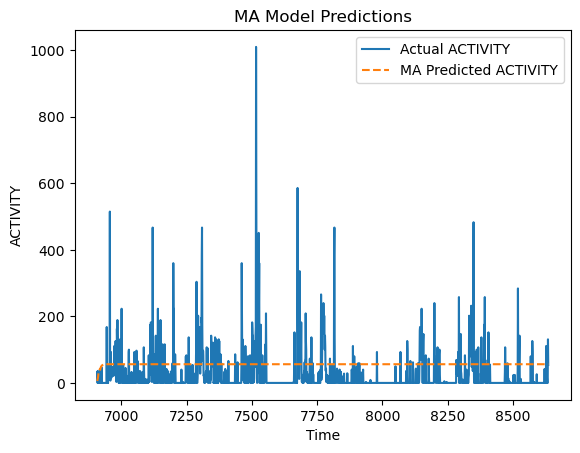

In [16]:
plt.plot(test_data['ACTIVITY'], label = 'Actual ACTIVITY')
plt.plot(pred_data['pred ACTIVITY'], label = 'MA Predicted ACTIVITY', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('ACTIVITY')
plt.legend()
plt.title('MA Model Predictions')
plt.show();

In [22]:
# calculate the mae and rmse for the model performance on the test set
mae = mean_absolute_error(y_test, ma_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test, ma_pred.flatten()))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 55.53
Root Mean Squared Error: 71.08


In [31]:
arima_model = ARIMA(y_train, order=(50, 0, 50)) # here is the MA(1) model
arima_results = ma_model.fit()

#summary of the model
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6908
Model:                ARIMA(0, 0, 25)   Log Likelihood              -39521.118
Date:                Mon, 31 Mar 2025   AIC                          79096.237
Time:                        20:14:57   BIC                          79280.929
Sample:                             0   HQIC                         79159.921
                               - 6908                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.2093      8.026      7.004      0.000      40.480      71.939
ma.L1          0.5421      0.006     95.005      0.000       0.531       0.553
ma.L2          0.3817      0.007     55.348      0.000       0.368       0.395
ma.L3          0.3436      0.008     43.951      0.000       0.328       0.359
ma.L4          0.2567      0.009     29.475      0.000       0.240       0.274
ma.L5          0.2795      0.009     31.179      0.000       0.262       0.297
ma.L6          0.2486      0.010     26.092      0.000       0.230       0.267
ma.L7          0.2315      0.009     24.567      0.000       0.213       0.250
ma.L8          0.2286      0.009     24.985      0.000       0.211       0.247
ma.L9          0.1953      0.010     19.488      0.000       0.176       0.215
ma.L10         0.1749      0.010     16.735      0.000       0.154       0.195
ma.L11         0.1939      0.011     17.920      0.000       0.173       0.215
ma.L12         0.2087      0.011     19.789      0.000       0.188       0.229
ma.L13         0.1990      0.010     19.916      0.000       0.179       0.219
ma.L14         0.2036      0.010     20.178      0.000       0.184       0.223
ma.L15         0.1712      0.011     16.199      0.000       0.150       0.192
ma.L16         0.1519      0.011     13.994      0.000       0.131       0.173
ma.L17         0.1289      0.010     12.491      0.000       0.109       0.149
ma.L18         0.1063      0.010     10.741      0.000       0.087       0.126
ma.L19         0.1054      0.010     10.083      0.000       0.085       0.126
ma.L20         0.1034      0.010     10.224      0.000       0.084       0.123
ma.L21         0.0897      0.010      9.300      0.000       0.071       0.109
ma.L22         0.0734      0.009      8.457      0.000       0.056       0.090
ma.L23         0.0395      0.009      4.262      0.000       0.021       0.058
ma.L24         0.0560      0.009      6.099      0.000       0.038       0.074
ma.L25         0.0434      0.009      4.870      0.000       0.026       0.061
sigma2      5453.9683     36.163    150.818      0.000    5383.091    5524.846
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            120618.31
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
arima_pred = arima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred ACTIVITY': arima_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred ACTIVITY
Time,
6908,5.843788
6909,10.766751
6910,13.421035
6911,20.715180
6912,26.174656


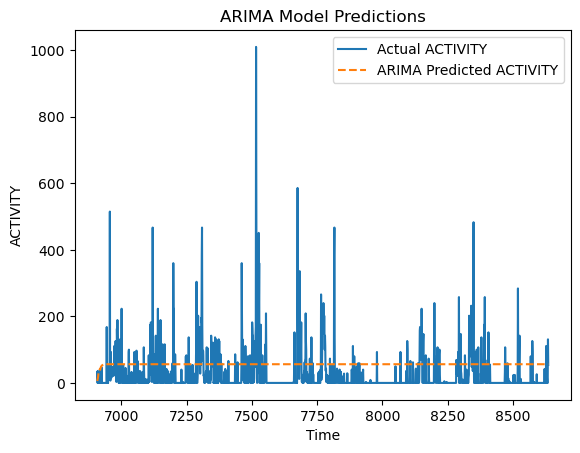

In [33]:
plt.plot(test_data['ACTIVITY'], label = 'Actual ACTIVITY')
plt.plot(pred_data['pred ACTIVITY'], label = 'ARIMA Predicted ACTIVITY', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('ACTIVITY')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show();

In [34]:
# calculate the mae and rmse for the model performance on the test set
mae = mean_absolute_error(y_test, arima_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test, arima_pred.flatten()))

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 55.53
Root Mean Squared Error: 71.08
